# Import libraries and initialize setup

In [1]:
import os 
import pandas as pd  
import spacy  
import random
import statistics
from PIL import Image  
from tqdm import tqdm
import copy

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.nn.utils.rnn import pad_sequence  
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models

import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu

spacy_eng = spacy.load("en")

from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/My Drive/Master's DS/Computer Vision CSCI-2271/Final Project/"
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1slfDnD2htWQW0hyg7pOTJg8hMvdyXWyC/Final Project


# Define functions for loading and preparing the data

In [2]:
class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1

                else:
                    frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]


class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, indices=None, transform=None, freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
        self.transform = transform

        # Get img, caption columns
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]

        # Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.captions.tolist())

        # Keep subset of data corresponding to the passed indices
        if indices:
          self.df = self.df.loc[indices].reset_index(drop=True)
        

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.imgs[index]
        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])

        return img, torch.tensor(numericalized_caption)

class Padder:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)

        return imgs, targets

def split_indicies(indices_list, split_percent):
  random.shuffle(indices_list)
  cutt_off = int(len(indices_list) * split_percent)
  return indices_list[0 : cutt_off], indices_list[cutt_off : ]


def expand_indices(indices):
  res = []
  for i in indices:
      for j in range(5):
        res.append(i+j)
  return res


def get_loader_and_indices(root_folder, annotation_file, transform):
    dataset = FlickrDataset(root_folder, annotation_file, transform=transform)

    shirnked_indicies = [i for i in range(0, len(dataset), 5)]
    train_val_indices, test_indices = split_indicies(shirnked_indicies, 0.9)
    train_indices, validation_indices = split_indicies(train_val_indices, 0.9)

    expanded_train_indices = expand_indices(train_indices)
    expanded_val_indices = expand_indices(validation_indices)
    expanded_test_indices = expand_indices(test_indices)

    train_dataset = FlickrDataset(root_folder, annotation_file, indices=expanded_train_indices, transform=transform)

    pad_idx = dataset.vocab.stoi["<PAD>"]
    
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=32,
        num_workers=8,
        shuffle=True,
        pin_memory=True,
        collate_fn=Padder(pad_idx=pad_idx),
    )

    return train_loader, expanded_val_indices, expanded_test_indices, dataset

# Define Models - Encoder & Decoder

In [3]:
class Encoder_CNN(nn.Module):
    def __init__(self, embed_dim, dropout_rate=0.5):
        super(Encoder_CNN, self).__init__()
        self.dropout_rate = dropout_rate
        self.cnn = models.inception_v3(pretrained=True, aux_logits=False)
        self.cnn.fc = nn.Linear(self.cnn.fc.in_features, embed_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(embed_dim, embed_dim)

        # We do not want to mess with pretrained CNN, so just fine tune last layers
        for name, param in self.cnn.named_parameters():
            if "fc.weight" in name or "fc.bias" in name:
                param.requires_grad = True
            else:
                param.requires_grad = False

    def forward(self, imgs):
        output = self.cnn(imgs)
        output = self.relu(output)
        output = self.dropout(output)
        output = self.fc(output)
        return output


class Decoder_LSTM(nn.Module):
    def __init__(self, embed_dim, hidden_dim, vocab_dim, dropout_rate=0.5):
        super(Decoder_LSTM, self).__init__()
        self.dropout_rate = dropout_rate
        self.dropout = nn.Dropout(dropout_rate)
        self.embedding = nn.Embedding(vocab_dim, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, 1)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, vocab_dim)
        

    def forward(self, input, caps):
        word_embeds = self.embedding(caps)
        word_embeds = self.dropout(word_embeds)
        word_embeds = torch.cat((input.unsqueeze(0), word_embeds), dim=0)
        h, s = self.lstm(word_embeds)
        output = self.fc1(h)
        output = self.fc2(output)
        return output

class EncoderToDecoder(nn.Module):
    def __init__(self, embed_dim, hidden_dim, vocab_dim, dropout_rate=0.5):
        super(EncoderToDecoder, self).__init__()
        self.encoder = Encoder_CNN(embed_dim, dropout_rate)
        self.decoder = Decoder_LSTM(embed_dim, hidden_dim, vocab_dim, dropout_rate)

    def forward(self, imgs, caps):
        output = self.encoder(imgs)
        output = self.decoder(output, caps)
        return output


# Load data and setup objects for training

In [4]:
transform = transforms.Compose(
    [
        transforms.Resize((356, 356)),
        transforms.RandomCrop((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_loader, validation_indices, test_indices, dataset = get_loader_and_indices(
    root_folder="/content/drive/My Drive/Master's DS/Computer Vision CSCI-2271/Final Project/data/flickr8k/Images",
    annotation_file="/content/drive/My Drive/Master's DS/Computer Vision CSCI-2271/Final Project/data/flickr8k/captions.txt",
    transform=transform
)


embed_dim = 512
dropout_rate = 0.5
hidden_dim = 512
vocab_dim = len(dataset.vocab)
lr = 4e-4

model = EncoderToDecoder(embed_dim, hidden_dim, vocab_dim, dropout_rate).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=lr)

# Define training/validation and helper functions

In [5]:
class BLEU_SCORES(object):
  def __init__(self, bleu1, bleu2, bleu3, bleu4, ind_bleu1, ind_bleu2, ind_bleu3, ind_bleu4):
    self.bleu1 = bleu1
    self.bleu2 = bleu2
    self.bleu3 = bleu3
    self.bleu4 = bleu4 

    self.ind_bleu1 = ind_bleu1
    self.ind_bleu2 = ind_bleu2
    self.ind_bleu3 = ind_bleu3
    self.ind_bleu4 = ind_bleu4

  def __str__(self):
    return ("Cumulative Scores: " +
    str(self.bleu1) + " " + str(self.bleu2) +" "+ str(self.bleu3) +" "+ str(self.bleu4) +". " +
    "Individual Scores: " +
    str(self.ind_bleu1) + " " + str(self.ind_bleu2) + " " + str(self.ind_bleu3) + " " + str(self.ind_bleu4))


def validate(model, dataset, indicies, print_sample=False):
  # Returns BLEU scores for the passed dataset and indices
  # Randomly prints one of the datapoint as sample example if print_sample is True
  model.eval()
  total_bleu1 = 0
  total_bleu2 = 0
  total_bleu3 = 0
  total_bleu4 = 0

  total_ind_bleu1 = 0
  total_ind_bleu2 = 0
  total_ind_bleu3 = 0
  total_ind_bleu4 = 0

  l = len(indicies)
  rand_idx = random.randint(0, l-1)
  for i in range(0, len(indicies), 5):
    idx = indicies[i]
    img, _ = dataset[idx]
    candidate = generate(model, img.unsqueeze(0).to(device), dataset.vocab, 50)
    reference = []
    for offset in range(5):
      img2, caps = dataset[idx + offset]
      reference.append([dataset.vocab.itos[j] for j in caps.squeeze().tolist()])

      if print_sample and rand_idx//5*5 == i:
        print("idx", idx + offset)
        show_image(img2, "idx" + str(idx + offset))
    
    if print_sample and rand_idx//5*5 == i:
      print("Random example during validation")
      print("reference", reference)
      print("candidate", candidate)
      print('Individual 1-gram: %f' % sentence_bleu(reference, candidate, weights=(1, 0, 0, 0)))
      print('Individual 2-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 1, 0, 0)))
      print('Individual 3-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 0, 1, 0)))
      print('Individual 4-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 0, 0, 1)))
      print('Cumulative 1-gram: %f' % sentence_bleu(reference, candidate, weights=(1, 0, 0, 0)))
      print('Cumulative 2-gram: %f' % sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0)))
      print('Cumulative 3-gram: %f' % sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.33, 0)))
      print('Cumulative 4-gram: %f' % sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25)))
      print("")

    bleu1 = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
    bleu2 = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
    bleu3 = sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.33, 0))
    bleu4 = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))

    ind_bleu1 = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
    ind_bleu2 = sentence_bleu(reference, candidate, weights=(0, 1, 0, 0))
    ind_bleu3 = sentence_bleu(reference, candidate, weights=(0, 0, 1, 0))
    ind_bleu4 = sentence_bleu(reference, candidate, weights=(0, 0, 0, 1))

    total_bleu1 += bleu1
    total_bleu2 += bleu2
    total_bleu3 += bleu3
    total_bleu4 += bleu4

    total_ind_bleu1 += ind_bleu1
    total_ind_bleu2 += ind_bleu2
    total_ind_bleu3 += ind_bleu3
    total_ind_bleu4 += ind_bleu4

  # Divide l by 5 to get number of examples
  l = l//5
  model.train()
  return BLEU_SCORES(total_bleu1/l, total_bleu2/l, total_bleu3/l, total_bleu4/l, total_ind_bleu1/l, total_ind_bleu2/l, total_ind_bleu3/l, total_ind_bleu4/l)

def show_image(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def print_random_example(model, dataset, indicies):
    idx = random.choice(indicies)
    idx = idx//5 * 5
    model.eval()
    img, caps = dataset[idx]
    show_image(img, "Image")
    for i in range(5):
      actual = " ".join([dataset.vocab.itos[j] for j in dataset[idx+i][1].squeeze().tolist()])
      print("Example idx:", idx, "TARGET :", actual)
    print("Example OUTPUT:", " ".join(generate(model, img.unsqueeze(0).to(device), dataset.vocab, 50)))
    model.train()


def generate(model, image, vocab, max_len):
    res = []

    with torch.no_grad():
        x = model.encoder(image).unsqueeze(0)
        states = None
        for i in range(max_len):
            hiddens, states = model.decoder.lstm(x, states)
            output = model.decoder.fc1(hiddens.squeeze(0))
            output = model.decoder.fc2(output)
            pred = output.argmax(1)
            x = model.decoder.embedding(pred).unsqueeze(0)

            res.append(pred.item())

            if vocab.itos[pred.item()] == "<EOS>":
                break

    return [vocab.itos[idx] for idx in res]


def train(model, criterion, opt, epochs, train_loader, validation_indices, test_indices, dataset, validate_interval):
    BELUs_list = []

    avg_losses = []
    best_model = None
    best_bleu4 = 0.0
    for epoch in range(epochs):
        print_random_example(model, dataset, validation_indices)
        print_random_example(model, dataset, validation_indices)
        print_random_example(model, dataset, validation_indices)
        model.train()

        total_loss = 0
        for i, (imgs, caps) in tqdm(enumerate(train_loader), total=len(train_loader), leave=False):
            caps = caps.to(device)
            imgs = imgs.to(device)
            output = model(imgs, caps[:-1])

            loss = criterion(output.reshape(-1, output.shape[2]), caps.reshape(-1))
            total_loss += loss.item()

            if i % validate_interval == 0:
              BLEUs = validate(model, dataset, validation_indices)
              avg_loss = total_loss/(i+1)
              total_loss = 0


              BELUs_list.append((BLEUs.bleu1, BLEUs.bleu4))
              avg_losses.append(avg_loss)
              if best_bleu4 < BLEUs.bleu4:
                  best_bleu4 = BLEUs.bleu4
                  best_model = copy.deepcopy(model)

              print("BLEU 1", BLEUs.bleu1, "BLEU 4", BLEUs.bleu4, "LOSS", loss.item())

            opt.zero_grad()
            loss.backward(loss)
            opt.step()

        print("EPOCH:", epoch, "LOSS:", avg_loss, "BLEU 1-4", BLEUs)

    return BELUs_list, avg_losses, best_model


# Run training

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


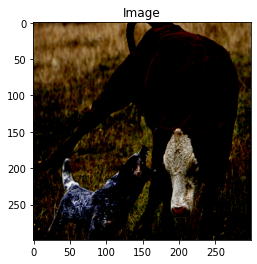

Example idx: 11660 TARGET : <SOS> a <UNK> barks at a cow . <EOS>
Example idx: 11660 TARGET : <SOS> a small dog barks at a brown and white cow . <EOS>
Example idx: 11660 TARGET : <SOS> a small dog is barking into a cow 's ear . <EOS>
Example idx: 11660 TARGET : <SOS> a small grey dog is in the grass with a brown cow . <EOS>
Example idx: 11660 TARGET : <SOS> the little dog is going after the bull . <EOS>
Example OUTPUT: gentleman homemade geese cloudy stores pyramid end blocked canvas kicking distance movie mohawk climb geese chess peaks costumed wooded purse hotel skiing hides parlor pain gear brightly accordion lone bears running milkshake booth handle goes genocide coach hitting conversing hitting maneuvers dried bathroom bathroom interesting upset indoor tulips carnival advertisement


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


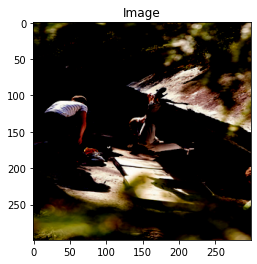

Example idx: 30850 TARGET : <SOS> one person is tumbling on the ground next to another person with his shoes off . <EOS>
Example idx: 30850 TARGET : <SOS> two boys , one is climbing a roof , the other is bending down looking at the ground . <EOS>
Example idx: 30850 TARGET : <SOS> two children playing on rocks <EOS>
Example idx: 30850 TARGET : <SOS> two people climbing some sort of object in the distance <EOS>
Example idx: 30850 TARGET : <SOS> two young people at park . <EOS>
Example OUTPUT: breaks eastern overpass stops breaks tries seal pyramid end shaved turn pounces them innertube shaved turn shot biker dancing dancing dancing basketball basketball teenager pigtails lady indoor target clover canoes handle bowler canyon breaks tries pictures hut there breaks tries seal florida canoes seal turn union driven michael florida innertube


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


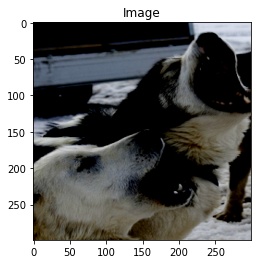

Example idx: 13640 TARGET : <SOS> snow dogs <UNK> . <EOS>
Example idx: 13640 TARGET : <SOS> these dogs appear to be <UNK> , outdoors in the snow . <EOS>
Example idx: 13640 TARGET : <SOS> three barking , <UNK> dogs <EOS>
Example idx: 13640 TARGET : <SOS> three dogs standing in the snow with two of the dogs with open mouths . <EOS>
Example idx: 13640 TARGET : <SOS> two husky dogs are <UNK> together <EOS>
Example OUTPUT: breaks eastern overpass stops breaks tries seal pyramid end shaved turn pounces them innertube shaved turn shot biker dancing dancing dancing basketball basketball teenager pigtails lady indoor target clover canoes handle bowler canyon breaks tries pictures hut there breaks tries seal florida canoes seal turn union driven michael florida innertube


  0%|          | 0/1024 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
  0%|          | 3/1024 [06:13<27:29:00, 96.91s/it]  

BLEU 1 0.0034019204389574786 BLEU 4 0.06062033219387208 LOSS 8.01254940032959


 10%|▉         | 99/1024 [06:21<01:14, 12.34it/s]/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
 10%|█         | 103/1024 [07:16<1:29:01,  5.80s/it]

BLEU 1 0.592834404229434 BLEU 4 0.5228563866860939 LOSS 3.7525787353515625


 20%|█▉        | 203/1024 [08:22<1:25:13,  6.23s/it]

BLEU 1 0.4002741788284564 BLEU 4 0.369152560515715 LOSS 3.4894421100616455


 30%|██▉       | 303/1024 [09:26<1:11:30,  5.95s/it]

BLEU 1 0.574538599743682 BLEU 4 0.49499841223767393 LOSS 3.475163698196411


 39%|███▉      | 403/1024 [10:30<1:02:02,  5.99s/it]

BLEU 1 0.5747938474828999 BLEU 4 0.5014637180265443 LOSS 3.161105155944824


 49%|████▉     | 503/1024 [11:34<51:38,  5.95s/it]  

BLEU 1 0.540988141292745 BLEU 4 0.4806081242648225 LOSS 3.385815143585205


 59%|█████▉    | 603/1024 [12:38<41:37,  5.93s/it]

BLEU 1 0.5351429751770362 BLEU 4 0.475711202022138 LOSS 3.230318784713745


 69%|██████▊   | 703/1024 [13:42<31:55,  5.97s/it]

BLEU 1 0.5115002130030936 BLEU 4 0.46014002771867335 LOSS 3.2039313316345215


 78%|███████▊  | 803/1024 [14:45<21:55,  5.95s/it]

BLEU 1 0.5786568399177994 BLEU 4 0.4947904370461829 LOSS 3.1695773601531982


 88%|████████▊ | 903/1024 [15:50<12:13,  6.07s/it]

BLEU 1 0.5129151701989124 BLEU 4 0.46241720416844273 LOSS 3.0857207775115967


 98%|█████████▊| 1003/1024 [17:03<02:24,  6.90s/it]

BLEU 1 0.12567901234567885 BLEU 4 0.21072629721020736 LOSS 3.0998666286468506


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


EPOCH: 0 LOSS: 0.30059116941827396 BLEU 1-4 Cumulative Scores: 0.12567901234567885 0.09037264439438512 0.14352054965854555 0.21072629721020736. Individual Scores: 0.12567901234567885 0.09996920578931176 0.6578932327389108 0.875813559816712


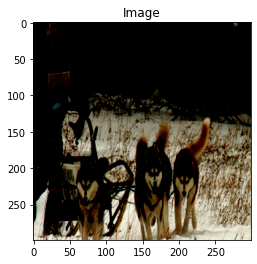

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Example idx: 22455 TARGET : <SOS> a man being pulled behind a sled <UNK> by numerous dogs in the snow . <EOS>
Example idx: 22455 TARGET : <SOS> a man dressed in warm clothing sleds behind four dogs in the snow . <EOS>
Example idx: 22455 TARGET : <SOS> a man is running behind a <UNK> being pulled by four dogs . <EOS>
Example idx: 22455 TARGET : <SOS> a man rides a sled pulled by a team of dogs . <EOS>
Example idx: 22455 TARGET : <SOS> four husky dogs are pulling a sled in a race through the snow <UNK> by a man wearing number <UNK> . <EOS>
Example OUTPUT: <SOS> a man in a red shirt is standing on a dirt track . <EOS>


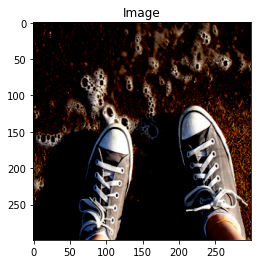

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Example idx: 37425 TARGET : <SOS> a closeup of grey and white shoes on the shore near the beach water . <EOS>
Example idx: 37425 TARGET : <SOS> a person wearing grey converse shoes <UNK> a picture of the water <UNK> touching their shoes . <EOS>
Example idx: 37425 TARGET : <SOS> a person wearing grey tennis shoes is standing right where the waves stop on the sand . <EOS>
Example idx: 37425 TARGET : <SOS> a shot of shoes in water . <EOS>
Example idx: 37425 TARGET : <SOS> the person wearing tennis shoes is standing on the sand . <EOS>
Example OUTPUT: <SOS> a man in a red shirt is standing on a dirt track . <EOS>


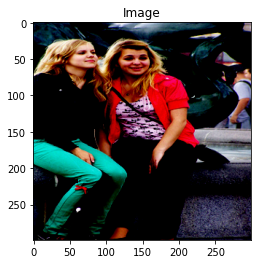

Example idx: 33755 TARGET : <SOS> a woman in green pants sits next to a woman in a pink jacket in front of statue of a fish . <EOS>
Example idx: 33755 TARGET : <SOS> two blonde girls are sitting next to a statue <EOS>
Example idx: 33755 TARGET : <SOS> two blond women are sitting by a fountain . <EOS>
Example idx: 33755 TARGET : <SOS> two girls are sitting in front of a statue . <EOS>
Example idx: 33755 TARGET : <SOS> two young women sit by a fountain . <EOS>
Example OUTPUT: <SOS> a man in a red shirt is standing on a dirt track . <EOS>


  0%|          | 3/1024 [00:58<4:16:39, 15.08s/it] 

BLEU 1 0.5448783015318762 BLEU 4 0.4748624177873394 LOSS 2.6466012001037598


 10%|█         | 103/1024 [02:03<1:34:16,  6.14s/it]

BLEU 1 0.573085020770697 BLEU 4 0.49952615530316324 LOSS 2.9727165699005127


 20%|█▉        | 203/1024 [03:11<1:27:15,  6.38s/it]

BLEU 1 0.4396893189854832 BLEU 4 0.4217149769103177 LOSS 2.9822232723236084


 30%|██▉       | 303/1024 [04:21<1:18:28,  6.53s/it]

BLEU 1 0.34513044638234497 BLEU 4 0.35278792661916814 LOSS 2.905787467956543


 39%|███▉      | 403/1024 [05:27<1:04:28,  6.23s/it]

BLEU 1 0.4860659824989488 BLEU 4 0.44314106706616696 LOSS 2.7326176166534424


 49%|████▉     | 503/1024 [06:40<59:26,  6.85s/it]  

BLEU 1 0.12913580246913564 BLEU 4 0.20929730191223933 LOSS 3.150658130645752


 59%|█████▉    | 603/1024 [07:44<42:06,  6.00s/it]  

BLEU 1 0.5224503737204728 BLEU 4 0.44743190176205155 LOSS 2.7202444076538086


 69%|██████▊   | 703/1024 [08:50<32:58,  6.16s/it]

BLEU 1 0.5263449306261898 BLEU 4 0.44195777630920546 LOSS 2.899054527282715


 78%|███████▊  | 803/1024 [09:53<21:52,  5.94s/it]

BLEU 1 0.5757116789336304 BLEU 4 0.4971828044846793 LOSS 2.824831008911133


 88%|████████▊ | 903/1024 [10:58<12:04,  5.99s/it]

BLEU 1 0.5161710778479401 BLEU 4 0.43808829459128673 LOSS 2.8987720012664795


 98%|█████████▊| 1003/1024 [12:02<02:07,  6.07s/it]

BLEU 1 0.47848790038814476 BLEU 4 0.4508891637031863 LOSS 2.799623489379883


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


EPOCH: 1 LOSS: 0.28115937402555635 BLEU 1-4 Cumulative Scores: 0.47848790038814476 0.3082182377795405 0.37279294696418 0.4508891637031863. Individual Scores: 0.47848790038814476 0.2022569383099837 0.7361744037622938 0.9007415685349628


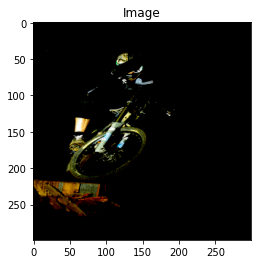

Example idx: 26910 TARGET : <SOS> a bicycler jumps a ramp outside in the dark night . <EOS>
Example idx: 26910 TARGET : <SOS> a man is sitting on a bike in the middle of the woods . <EOS>
Example idx: 26910 TARGET : <SOS> a person doing a trick on a bike <EOS>
Example idx: 26910 TARGET : <SOS> a person in a black jacket is jumping through the air on a bike . <EOS>
Example idx: 26910 TARGET : <SOS> man on a motorcycle performing a trick in the air . <EOS>
Example OUTPUT: <SOS> a man in a blue shirt is standing on a sidewalk . <EOS>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


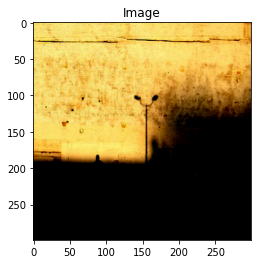

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Example idx: 2245 TARGET : <SOS> a man in the near distance is pointing to a silver <UNK> near him . <EOS>
Example idx: 2245 TARGET : <SOS> a man is playing tennis with himself against a large wall in a parking lot . <EOS>
Example idx: 2245 TARGET : <SOS> a man walks toward a car in a parking lot . <EOS>
Example idx: 2245 TARGET : <SOS> man stands outside against wall with tennis racket in dark . <EOS>
Example idx: 2245 TARGET : <SOS> the man is playing tennis against the building . <EOS>
Example OUTPUT: <SOS> a man in a blue shirt is standing on a sidewalk . <EOS>


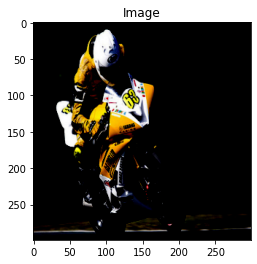

Example idx: 26145 TARGET : <SOS> a man in a yellow outfit riding a yellow motorcycle . <EOS>
Example idx: 26145 TARGET : <SOS> a motorcyclist in yellow . <EOS>
Example idx: 26145 TARGET : <SOS> a motorcyclist in yellow and white rides his bike . <EOS>
Example idx: 26145 TARGET : <SOS> a yellow motorcycle drives down the road . <EOS>
Example idx: 26145 TARGET : <SOS> a yellow motorcycle is being ridden on a racetrack . <EOS>
Example OUTPUT: <SOS> a man in a blue shirt is standing on a sidewalk . <EOS>


  0%|          | 3/1024 [00:56<4:09:50, 14.68s/it] 

BLEU 1 0.5759822043082881 BLEU 4 0.49382541141839775 LOSS 2.7392165660858154


 10%|█         | 103/1024 [02:03<1:36:05,  6.26s/it]

BLEU 1 0.44312139091225594 BLEU 4 0.402946181456879 LOSS 2.6706197261810303


 20%|█▉        | 203/1024 [03:09<1:24:04,  6.14s/it]

BLEU 1 0.4968250325965111 BLEU 4 0.4276213401883052 LOSS 2.8253345489501953


 30%|██▉       | 303/1024 [04:12<1:11:03,  5.91s/it]

BLEU 1 0.5549818292708959 BLEU 4 0.5029736893491386 LOSS 2.8232014179229736


 39%|███▉      | 403/1024 [05:16<1:02:23,  6.03s/it]

BLEU 1 0.4826027913357927 BLEU 4 0.4563397543205774 LOSS 2.672640562057495


 49%|████▉     | 503/1024 [06:22<53:33,  6.17s/it]  

BLEU 1 0.4595825273181669 BLEU 4 0.4294726169936208 LOSS 2.4759867191314697


 59%|█████▉    | 603/1024 [07:30<44:21,  6.32s/it]  

BLEU 1 0.35072627255863653 BLEU 4 0.3496244027081894 LOSS 2.6578752994537354


 60%|█████▉    | 611/1024 [07:30<10:44,  1.56s/it]

In [ ]:
BELUs_list, avg_losses, best_model = train(model, criterion, optimizer, 15, train_loader, validation_indices, test_indices, dataset, 100)
print(BELUs_list)
print(avg_losses)

# Get BLEU scores for Test data

In [ ]:
BLEUs = validate(best_model, dataset, test_indices)
print("BLEU 1", BLEUs.bleu1, "BLEU 4", BLEUs.bleu4)